In [1]:
import sys
sys.path.insert(0, "../../python")

import os
from ionization import ionization
from ionization import adk
from propagation import propagation
from propagation import laser
from propagation import plasma
from lens import profile
from lens import bessel
from lens import ray
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import integrate
from scipy.optimize import curve_fit
from gs import gs
from numpy.fft import fft, fft2, fftshift, fftfreq

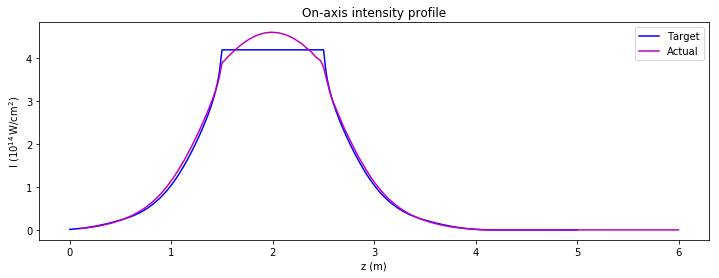

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 5000,
          'M' : 5000,
          'R' : 0.3e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 6e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 10e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:5000]/1e6, I[0:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

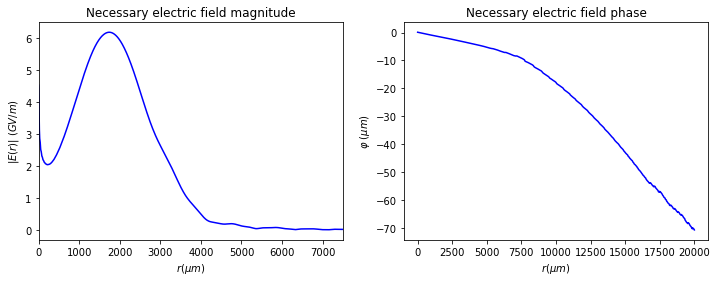

In [3]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title(r'Necessary electric field magnitude')
plt.xlim([0, 7500])

plt.subplot(122)
plt.plot(rm, phi/k, 'b-')
plt.xlabel(r'$r (\mu m)$')
plt.ylabel(r'$\varphi$ ($\mu m$)')
plt.title(r'Necessary electric field phase')
plt.show()

In [4]:
# First find the total power coming out of the optics
Iout = ionization.intensity_from_field(E)
Pout = integrate.simps(Iout * 2*np.pi*rm, rm)
print('Power through optics: ', Pout/1e6, 'TW')

Power through optics:  0.923542110804 TW


In [5]:
# Define the input beam and geometric setup
lam = 0.8
w0 = 10e3 # Initial Gaussian width
L = 25e4 # Spacing between phase masks

# Calculate the amplitude of the input beam
Iin = 2*Pout / (np.pi*w0**2)
E0 = ionization.field_from_intensity(Iin)
print('Peak field of Gaussian input beam: ', E0, 'GV/m')

def Efunc(x, y):
    # Input Gaussian beam
    r2 = x**2 + y**2
    E0 = np.exp(-r2 / params['w0']**2)
    # Input flatop beam
    #E0 = np.zeros((np.size(x), np.size(y)))
    #E0[r2 < params['w0']**2] = 1.0
    return E0

# Setup the parameters
params = {'Nx' : 2**8,
          'Ny' : 2**8,
          'X' : 15e3,
          'Y' : 15e3,
          'lam' : lam,
          'E0' : E0,
          'n' : 1.0,
          'w0' : w0,
          }

path = '/media/robert/Data_Storage/Data/Optics/TripleAxicon/'

Peak field of Gaussian input beam:  2.10473830212 GV/m


In [6]:
# Designing the first phase mask using G-S
Nx = params['Nx']
Ny = params['Ny']
X = params['X']
Y = params['Y']
Ef = interp1d(rm, abs(E))
x = np.linspace(-X/2, X/2, Nx, False)
x = np.reshape(x, (Nx, 1))
y = np.linspace(-Y/2, Y/2, Ny, False)

source = Efunc(x, y)*E0#*np.exp(-1j*20*np.sqrt(x**2+y**2))
target = Ef(np.sqrt(x**2+y**2))
phiGS = gs.gs2(source, target)
sourceP = abs(source) * np.exp(1j*phiGS)
sourceF = fft(sourceP)/np.sqrt(N)

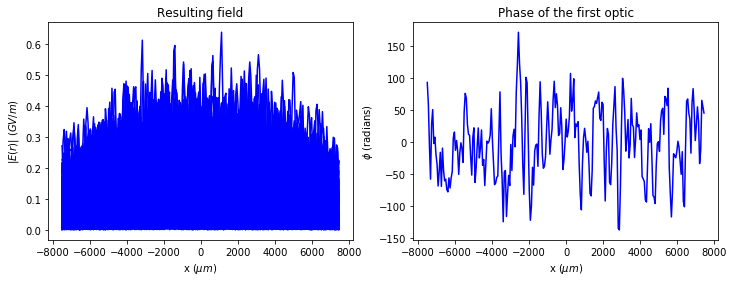

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(x, abs(sourceF), 'b-')
plt.title('Resulting field')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.subplot(122)
plt.plot(x, phiGS[:, int(Ny/2)], 'b-')
plt.title('Phase of the first optic')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$ (radians)')
plt.show()

Power in:  0.923491303239 TW


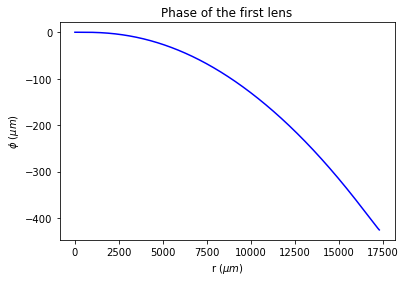

In [8]:
# Let' see if we can develop a geometric optics approach
rmax1 = 25e3
N = 5000
rin = np.linspace(0, rmax1, N)
I0 = ionization.intensity_from_field(E0*np.exp(-rin**2 / params['w0']**2))
r1, phi1 = ray.lens_design(I0, rin, Iout, rm, L)
# Check to make sure the power is the same
Pin = integrate.simps(I0 * 2*np.pi*rin, rin)
print('Power in: ', Pin/1e6, 'TW')

plt.plot(r1, phi1, 'b-')
plt.title('Phase of the first lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.show()

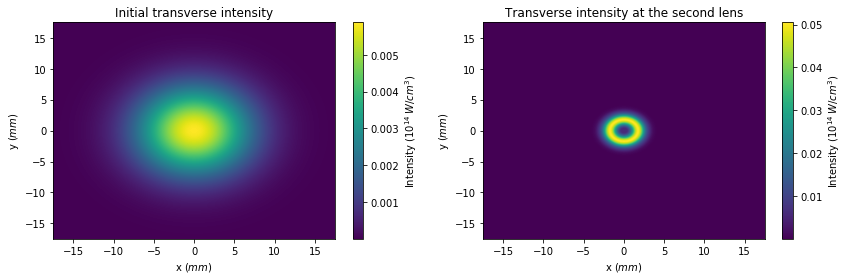

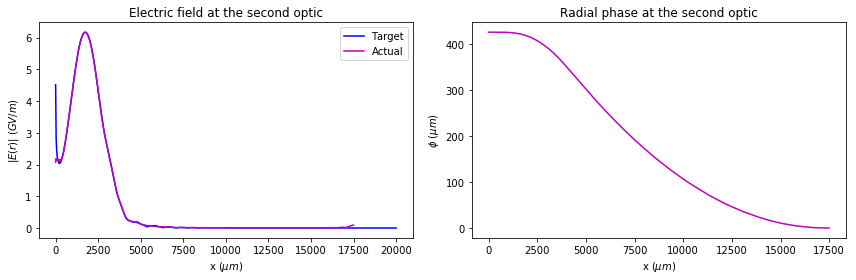

In [9]:
# Fourier propagator to test the phase mask
# Initialize the grid
X = 35e3
Y = 35e3
Nx = 2**13
Ny = 2**13

x = np.linspace(-X/2, X/2, Nx, False)
y = np.linspace(-Y/2, Y/2, Ny, False)
xe = np.reshape(x, (Nx, 1))
ye = np.reshape(y, (1, Ny))

# Calculate the initial electric field on the boundary
phie = interp1d(r1, phi1*k, bounds_error=False, fill_value=0.0)
re = np.sqrt(xe**2 + ye**2)
E1 = E0 * np.exp(-re**2 / params['w0']**2) * np.exp(1j*phie(re))

# Propogate the field to the second lens
E2 = laser.fourier_prop2(E1, x, y, [L], params['lam'], n=params['n'])

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(propagation.prep_data(E1[:, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial transverse intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(122)
plt.imshow(propagation.prep_data(E2[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the second lens')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-', 
         x[int(Nx/2):], abs(E2[0, :, int(Ny/2)])[int(Nx/2):], 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title('Electric field at the second optic')
plt.legend(['Target', 'Actual'])

plt.subplot(122)
plt.plot(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):]/k, 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.title('Radial phase at the second optic')

plt.tight_layout()
plt.show()

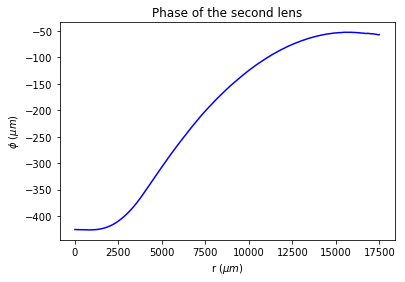

In [10]:
# Second phase element
phiF = interp1d(rm, phi)
phiInto2 = interp1d(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):])

Efield = interp1d(x[int(Nx/2):], E2[0, :, int(Ny/2)][int(Nx/2):])
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    phase = params['phase']
    E0 = Efield(r) * np.exp(1j*phase(r))
    return E0

# Setup the parameters
params = {'Nx' : 2**12,
          'Ny' : 2**7,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 10e3,
          'Y' : 10e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield
          }

path = '/media/robert/Data_Storage/Data/Optics/TwoPhaseMask/'

# Create the second phase mask
r2 = np.linspace(0, X/2, int(Nx/2), False)
phi2 = phiF(r2) - phiInto2(r2)
phi2F = interp1d(r2, phi2)
params['phase'] = phi2F

plt.plot(r2, phi2/k, 'b-')
plt.title('Phase of the second lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.show()

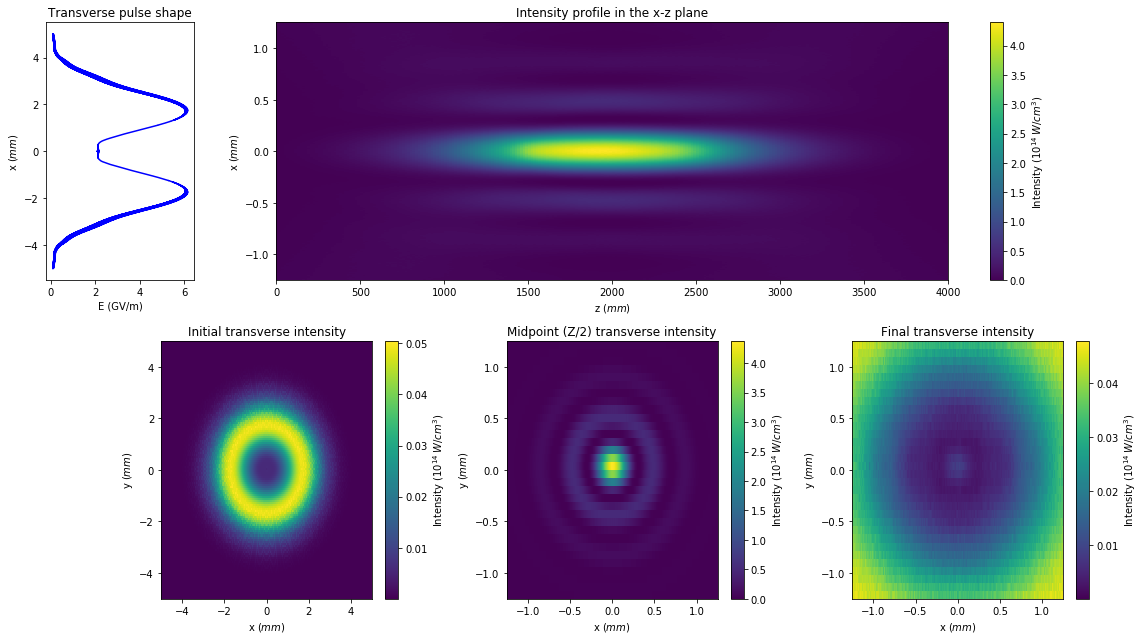

In [11]:
directory = 'Plasma_Field'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

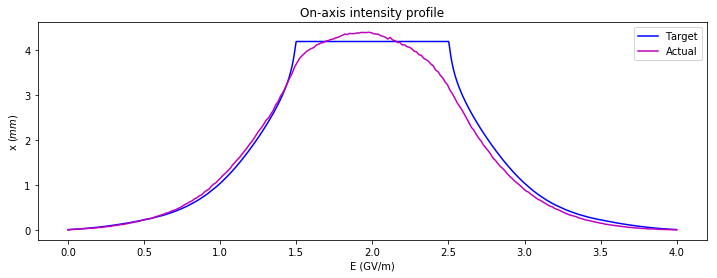

In [12]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()

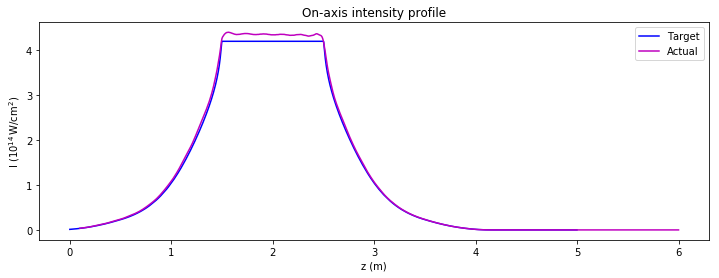

In [13]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 5000,
          'M' : 5000,
          'R' : 0.1e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 6e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 15e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:5000]/1e6, I[0:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

In [14]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))
# First find the total power coming out of the optics
Iout = ionization.intensity_from_field(E)
Pout = integrate.simps(Iout * 2*np.pi*rm, rm)
print('Power through optics: ', Pout/1e6, 'TW')

# Let' see if we can develop a geometric optics approach
# Define the input beam and geometric setup
lam = 0.8
w0 = 10e3 # Initial Gaussian width
L = 25e4 # Spacing between phase masks

# Calculate the amplitude of the input beam
Iin = 2*Pout / (np.pi*w0**2)
E0 = ionization.field_from_intensity(Iin)
print('Peak field of Gaussian input beam: ', E0, 'GV/m')

rmax1 = 25e3
N = 5000
rin = np.linspace(0, rmax1, N)
I0 = ionization.intensity_from_field(E0*np.exp(-rin**2 / w0**2))
r1, phi1 = ray.lens_design(I0, rin, Iout, rm, L)
# Check to make sure the power is the same
Pin = integrate.simps(I0 * 2*np.pi*rin, rin)
print('Power in: ', Pin/1e6, 'TW')

Power through optics:  0.924821243692 TW
Peak field of Gaussian input beam:  2.10619535989 GV/m
Power in:  0.924770365757 TW


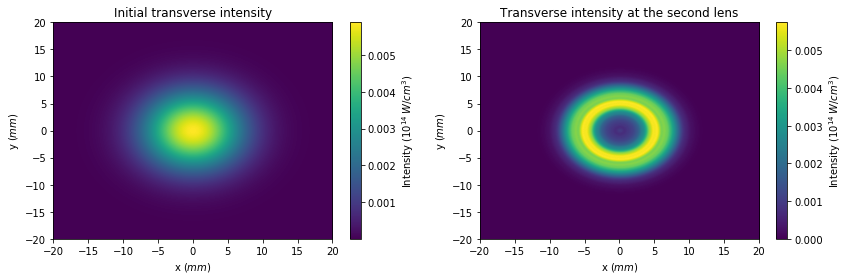

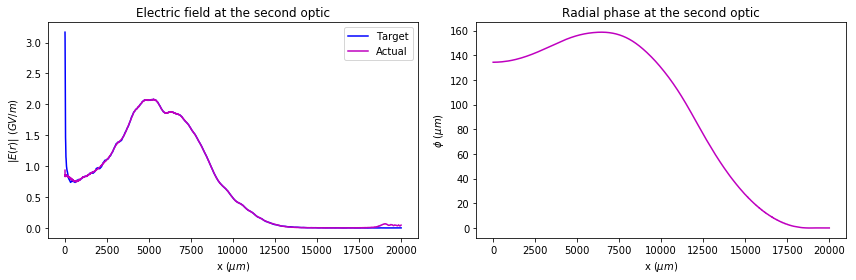

In [15]:
# Fourier propagator to test the phase mask
# Initialize the grid
X = 40e3
Y = 40e3
Nx = 2**13
Ny = 2**13

x = np.linspace(-X/2, X/2, Nx, False)
y = np.linspace(-Y/2, Y/2, Ny, False)
xe = np.reshape(x, (Nx, 1))
ye = np.reshape(y, (1, Ny))

# Calculate the initial electric field on the boundary
phie = interp1d(r1, phi1*k, bounds_error=False, fill_value=0.0)
re = np.sqrt(xe**2 + ye**2)
E1 = E0 * np.exp(-re**2 / w0**2) * np.exp(1j*phie(re))

# Propogate the field to the second lens
E2 = laser.fourier_prop2(E1, x, y, [L], lam)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(propagation.prep_data(E1[:, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial transverse intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(122)
plt.imshow(propagation.prep_data(E2[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the second lens')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-', 
         x[int(Nx/2):], abs(E2[0, :, int(Ny/2)])[int(Nx/2):], 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title('Electric field at the second optic')
plt.legend(['Target', 'Actual'])

plt.subplot(122)
plt.plot(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):]/k, 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.title('Radial phase at the second optic')

plt.tight_layout()
plt.show()

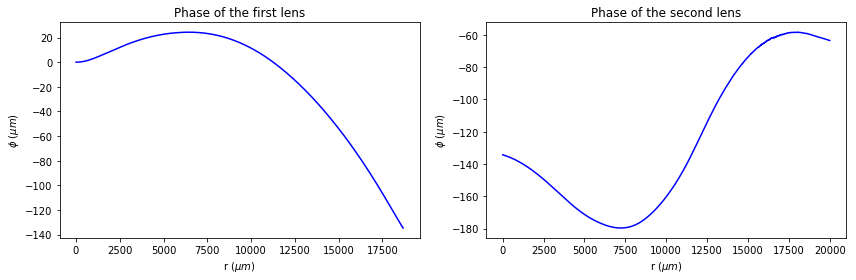

In [16]:
# Second phase element
phiF = interp1d(rm, phi)
phiInto2 = interp1d(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):])

Efield = interp1d(x[int(Nx/2):], E2[0, :, int(Ny/2)][int(Nx/2):])
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    phase = params['phase']
    E0 = Efield(r) * np.exp(1j*phase(r))
    return E0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 25e3,
          'Y' : 25e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield
          }

path = '/media/robert/Data_Storage/Data/Optics/TwoPhaseMask/'

# Create the second phase mask
r2 = np.linspace(0, X/2, int(Nx/2), False)
phi2 = phiF(r2) - phiInto2(r2)
phi2F = interp1d(r2, phi2)
params['phase'] = phi2F

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(r1, phi1, 'b-')
plt.title('Phase of the first lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')

plt.subplot(122)
plt.plot(r2, phi2/k, 'b-')
plt.title('Phase of the second lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')

plt.tight_layout()
plt.show()

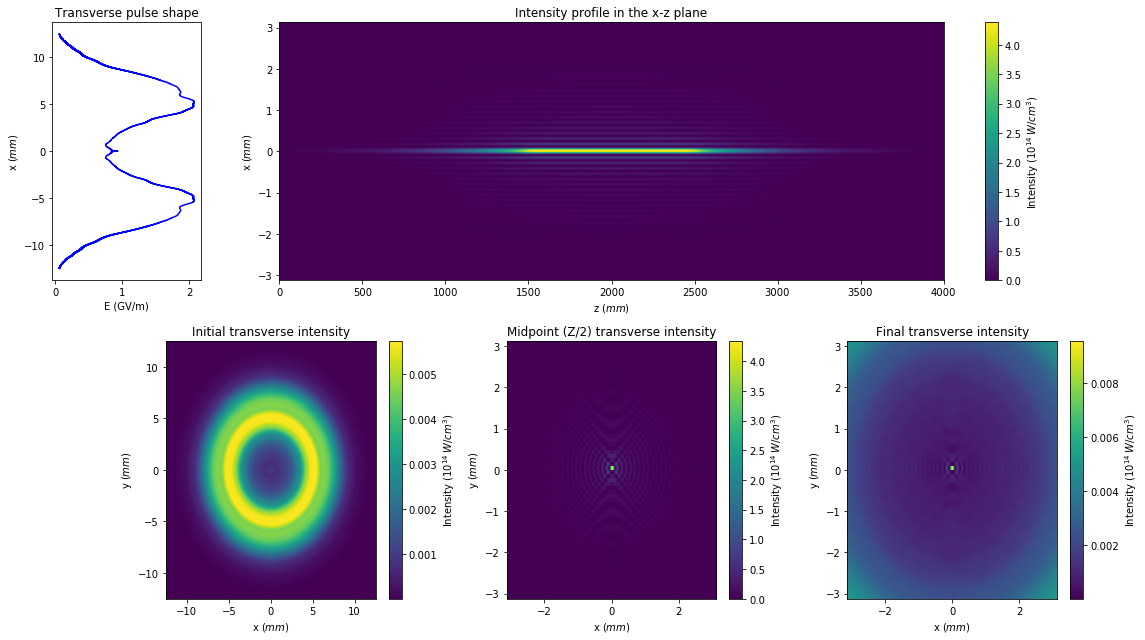

In [17]:
directory = 'Plasma_Field_100um'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

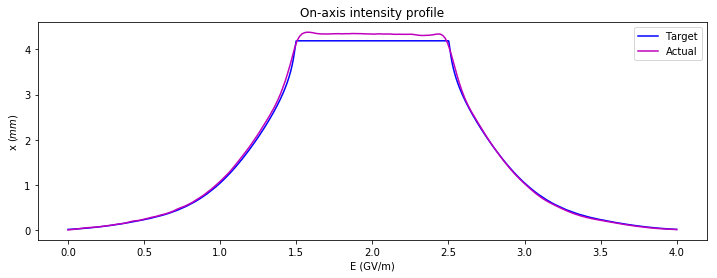

In [18]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()

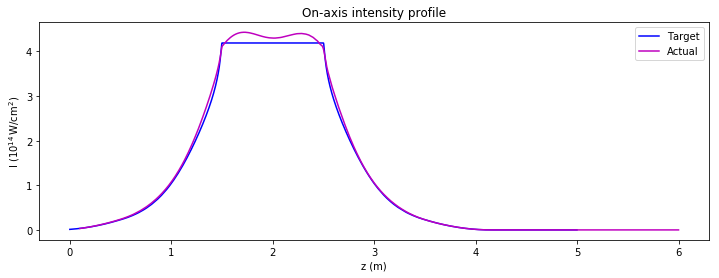

In [19]:
# Create the desired intensity profile
ion = {'atom' : ionization.H2,
       'tau' : 50,
       'type' : 'gaussian'}
z0 = 1.5e6
zf = 50e6
dz = 1e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 50000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

# Calculate the electric field
params = {'N' : 5000,
          'M' : 5000,
          'R' : 0.2e3,
          'lam' : 0.8,
          'rmax' : 20e3
         }
Ez = ionization.field_from_intensity(I)
rm, E = bessel.uniform_bessel(params, Ez, z)
E = E*8.15e6

zFres = np.linspace(1e5, 6e6, 1000)
Efield = interp1d(rm, E)
r = np.linspace(0, 15e3, 10000)
E0 = Efield(r)

e = laser.fresnel_axis(E0, r, zFres, params['lam'])
IFres = ionization.intensity_from_field(abs(e))

plt.figure(figsize={12, 4})
plt.plot(z[0:5000]/1e6, I[0:5000], 'b-', zFres/1e6, IFres, 'm-')
plt.title('On-axis intensity profile')
plt.xlabel('z (m)')
plt.ylabel(r'I ($10^{14}\,\mathrm{W/cm}^2$)')
plt.legend(['Target', 'Actual'])
plt.show()

In [20]:
k = 2*np.pi/params['lam']
phi = np.unwrap(np.angle(E))
# First find the total power coming out of the optics
Iout = ionization.intensity_from_field(E)
Pout = integrate.simps(Iout * 2*np.pi*rm, rm)
print('Power through optics: ', Pout/1e6, 'TW')

# Let' see if we can develop a geometric optics approach
# Define the input beam and geometric setup
lam = 0.8
w0 = 10e3 # Initial Gaussian width
L = 25e4 # Spacing between phase masks

# Calculate the amplitude of the input beam
Iin = 2*Pout / (np.pi*w0**2)
E0 = ionization.field_from_intensity(Iin)
print('Peak field of Gaussian input beam: ', E0, 'GV/m')

rmax1 = 25e3
N = 5000
rin = np.linspace(0, rmax1, N)
I0 = ionization.intensity_from_field(E0*np.exp(-rin**2 / w0**2))
r1, phi1 = ray.lens_design(I0, rin, Iout, rm, L)
# Check to make sure the power is the same
Pin = integrate.simps(I0 * 2*np.pi*rin, rin)
print('Power in: ', Pin/1e6, 'TW')

Power through optics:  0.924856235133 TW
Peak field of Gaussian input beam:  2.10623520441 GV/m
Power in:  0.924805355273 TW


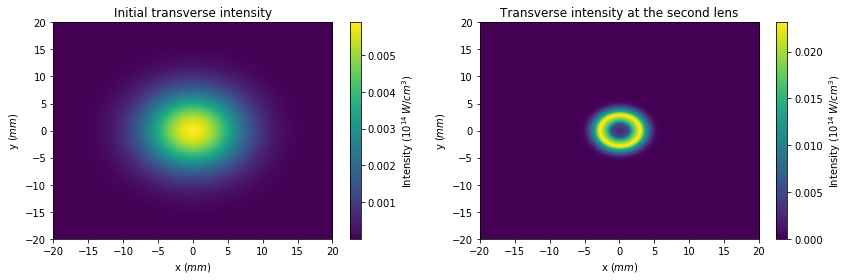

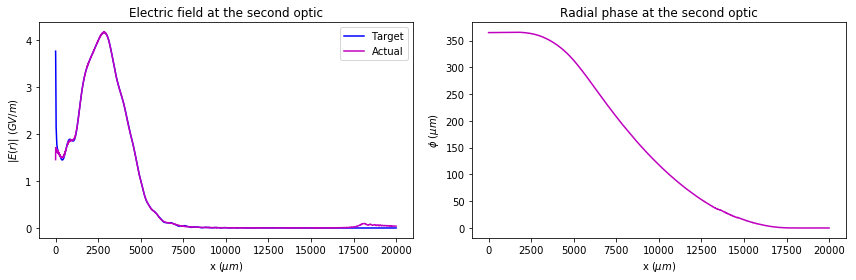

In [21]:
# Fourier propagator to test the phase mask
# Initialize the grid
X = 40e3
Y = 40e3
Nx = 2**13
Ny = 2**13

x = np.linspace(-X/2, X/2, Nx, False)
y = np.linspace(-Y/2, Y/2, Ny, False)
xe = np.reshape(x, (Nx, 1))
ye = np.reshape(y, (1, Ny))

# Calculate the initial electric field on the boundary
phie = interp1d(r1, phi1*k, bounds_error=False, fill_value=0.0)
re = np.sqrt(xe**2 + ye**2)
E1 = E0 * np.exp(-re**2 / w0**2) * np.exp(1j*phie(re))

# Propogate the field to the second lens
E2 = laser.fourier_prop2(E1, x, y, [L], lam)

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.imshow(propagation.prep_data(E1[:, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Initial transverse intensity')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.subplot(122)
plt.imshow(propagation.prep_data(E2[0, :, :]),
               aspect='auto',
               extent=[-X/2e3, X/2e3, -Y/2e3, Y/2e3])
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,W/cm^3$)')
plt.set_cmap('viridis')
plt.xlabel(r'x ($mm$)')
plt.ylabel(r'y ($mm$)')
plt.title('Transverse intensity at the second lens')
plt.xlim([-X/2e3, X/2e3])
plt.ylim([-Y/2e3, Y/2e3])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(rm, abs(E), 'b-', 
         x[int(Nx/2):], abs(E2[0, :, int(Ny/2)])[int(Nx/2):], 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$|E(r)|$ $(GV/m)$')
plt.title('Electric field at the second optic')
plt.legend(['Target', 'Actual'])

plt.subplot(122)
plt.plot(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):]/k, 'm-')
plt.xlabel(r'x ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')
plt.title('Radial phase at the second optic')

plt.tight_layout()
plt.show()

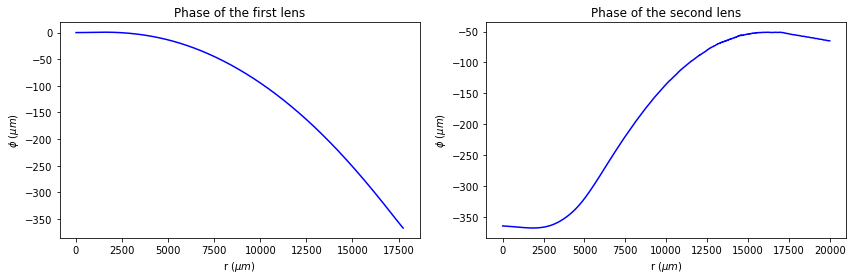

In [22]:
# Second phase element
phiF = interp1d(rm, phi)
phiInto2 = interp1d(x[int(Nx/2):], np.unwrap(np.angle(E2[0, :, int(Ny/2)]))[int(Nx/2):])

Efield = interp1d(x[int(Nx/2):], E2[0, :, int(Ny/2)][int(Nx/2):])
def Efunc(x, y):
    r = np.sqrt(x**2 + y**2)
    Efield = params['Efield']
    phase = params['phase']
    E0 = Efield(r) * np.exp(1j*phase(r))
    return E0

# Setup the parameters
params = {'Nx' : 2**11,
          'Ny' : 2**8,
          'Nz' : 2**8,
          'Nt' : 2**6,
          'X' : 20e3,
          'Y' : 20e3,
          'Z' : 4e6,
          'n0' : 0.5,
          'E0' : 1.0,
          'lam' : lam,
          'n' : 1.0,
          'Efield' : Efield
          }

path = '/media/robert/Data_Storage/Data/Optics/TwoPhaseMask/'

# Create the second phase mask
r2 = np.linspace(0, X/2, int(Nx/2), False)
phi2 = phiF(r2) - phiInto2(r2)
phi2F = interp1d(r2, phi2)
params['phase'] = phi2F

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(r1, phi1, 'b-')
plt.title('Phase of the first lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')

plt.subplot(122)
plt.plot(r2, phi2/k, 'b-')
plt.title('Phase of the second lens')
plt.xlabel(r'r ($\mu m$)')
plt.ylabel(r'$\phi$ ($\mu m$)')

plt.tight_layout()
plt.show()

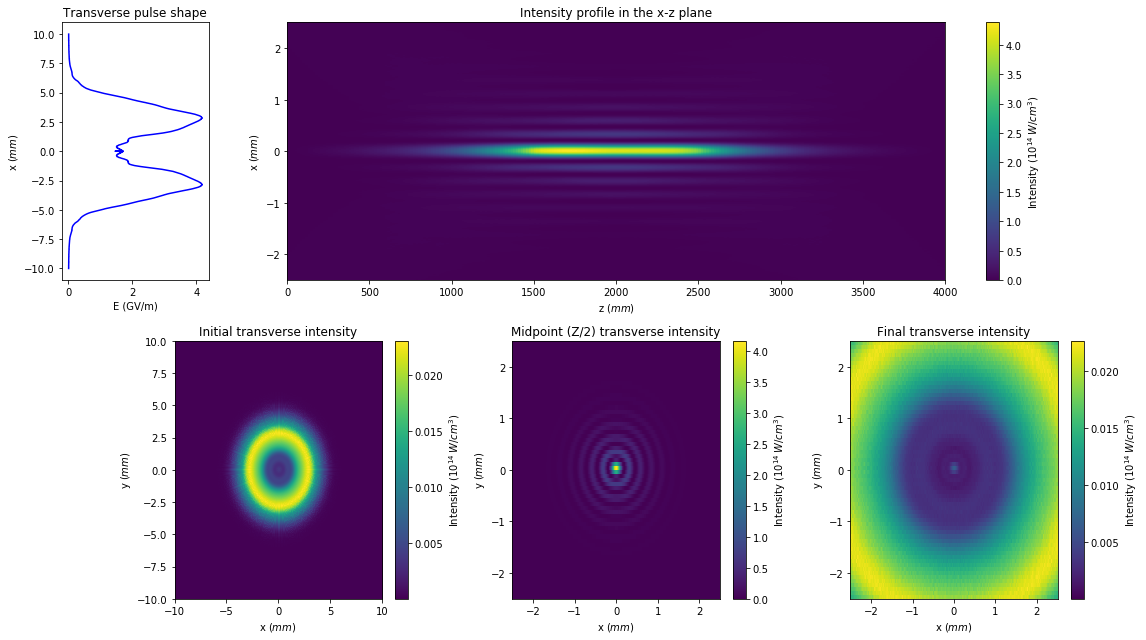

In [23]:
directory = 'Plasma_Field_200um'
params['path'] = path + directory+'/'
# Create the directory if it doesn't exist
if not os.path.exists(params['path']):
    os.makedirs(params['path'])
# Simulate free space propagation
propagation.laser_prop(params, Efunc)
propagation.laser_prop_plot(params['path'])

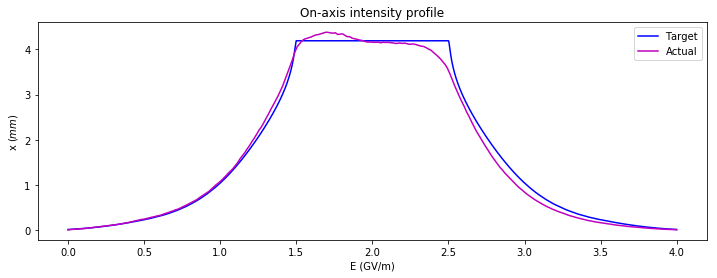

In [24]:
Eplot = np.load(params['path']+'electricField.npy')
Nx = params['Nx']
Ny = params['Ny']
Nz = params['Nz']
Z = params['Z']

zplot = np.linspace(0, Z, Nz)

Eplot = ionization.intensity_from_field(abs(Eplot[:, int(Nx/2), int(Ny/2)]))

plt.figure(figsize={12, 4})
plt.plot(z[0:4000]/1e6, I[0:4000], 'b-', zplot/1e6, Eplot, 'm-')
plt.xlabel(r'E (GV/m)')
plt.ylabel(r'x ($mm$)')
plt.title('On-axis intensity profile')
plt.legend(['Target', 'Actual'])
plt.show()